In [13]:
from imports_bib import *
from import_data import load_kaggle_dataset
from config_data import config

In [14]:
df = load_kaggle_dataset(
    dataset_name=config["dataset_name"],
    zip_file_name=config["zip_file_name"],
    csv_file_name=config["csv_file_name"],
    data_path=config["data_path"]
)

print(df.head())

Dataset URL: https://www.kaggle.com/datasets/adilshamim8/math-students
Pliki w ZIP: ['Math-Students.csv']
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 r

In [15]:
target = 'G3'
# df = df.drop(columns=['G1', 'G2'])

X = df.drop(columns=[target])
y = df[target]

In [16]:
categorical_features = X.select_dtypes(include='object').columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [27]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
])


def select_features(X, y):
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42))
    ])
    pipe.fit(X, y)
    model = pipe.named_steps['model']
    X_preprocessed = pipe.named_steps['preprocessor'].transform(X)
    selector = SelectFromModel(model, prefit=True)
    return selector, X_preprocessed, pipe

selector, X_transformed, full_pipe = select_features(X, y)
X_selected = selector.transform(X_transformed)

[[-0.40433066  0.04369327 -1.24508286  0.          0.          1.        ]
 [-0.40433066 -0.20715011 -1.51131441  0.          0.          0.        ]
 [-0.40433066  0.54538002 -0.71261977  0.          0.          1.        ]
 ...
 [ 0.31911299 -0.70883686 -0.97885132  1.          0.          1.        ]
 [ 0.31911299 -0.70883686 -0.97885132  1.          0.          1.        ]
 [ 0.31911299 -0.70883686 -0.97885132  1.          0.          1.        ]]


In [29]:
# nazwy wybranych cech
feature_names = full_pipe.named_steps['preprocessor'].get_feature_names_out()
selected_mask = selector.get_support()
selected_features = feature_names[selected_mask]
print("Wybrane cechy:")
print(selected_features)

Wybrane cechy:
['num__health' 'num__absences' 'num__G2' 'cat__school_MS'
 'cat__reason_home' 'cat__guardian_mother']


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [19]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 400),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }
    model = XGBRegressor(**params, random_state=42)
    return -cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3).mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2025-09-13 12:56:47,365] A new study created in memory with name: no-name-b6aaacdc-0b49-41e5-a969-70776b11f33f
[I 2025-09-13 12:56:47,912] Trial 0 finished with value: 4.555928548177083 and parameters: {'n_estimators': 226, 'max_depth': 8, 'learning_rate': 0.19990808552186537, 'subsample': 0.7511708692897225, 'colsample_bytree': 0.5306928172986309}. Best is trial 0 with value: 4.555928548177083.
[I 2025-09-13 12:56:48,297] Trial 1 finished with value: 3.3131104707717896 and parameters: {'n_estimators': 198, 'max_depth': 8, 'learning_rate': 0.23213255145937253, 'subsample': 0.5953528735911294, 'colsample_bytree': 0.886494309048228}. Best is trial 1 with value: 3.3131104707717896.
[I 2025-09-13 12:56:48,521] Trial 2 finished with value: 3.6757922967274985 and parameters: {'n_estimators': 156, 'max_depth': 6, 'learning_rate': 0.26585180804666103, 'subsample': 0.631213090450039, 'colsample_bytree': 0.7620948751500627}. Best is trial 1 with value: 3.3131104707717896.
[I 2025-09-13 12:56:

In [20]:
final_model = XGBRegressor(**study.best_params, random_state=42)
final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9838074379115852, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.014720325547765723,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=316, n_jobs=None,
             num_parallel_tree=None, ...)

In [21]:
# Ewaluacja
y_pred = final_model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 2.5745432376861572
MAE: 1.0351154804229736
R²: 0.8753766417503357


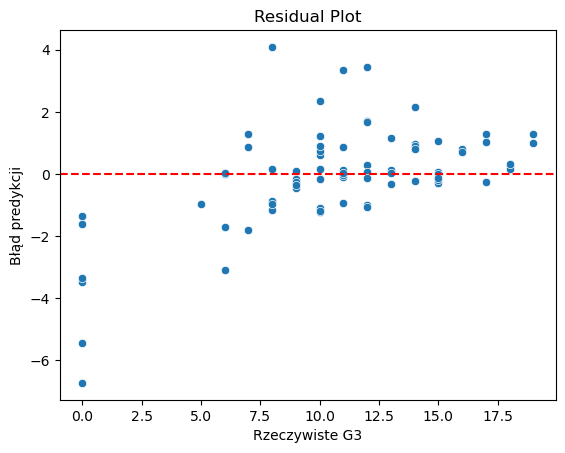

In [22]:
# Residual plot
sns.scatterplot(x=y_test, y=y_test - y_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Rzeczywiste G3")
plt.ylabel("Błąd predykcji")
plt.title("Residual Plot")
plt.show()


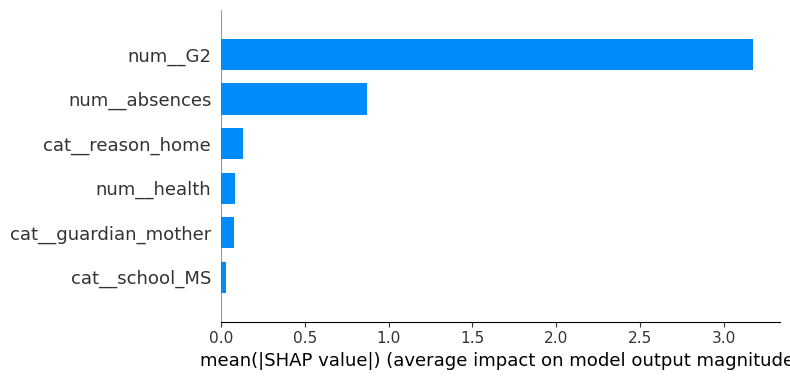

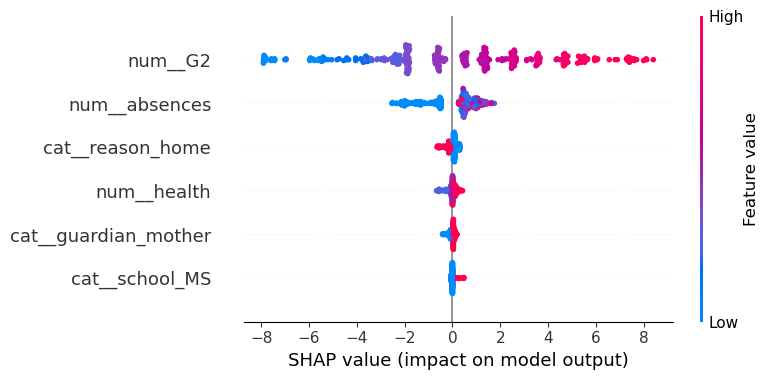

In [30]:
# SHAP interpretacja

X_train_selected = pd.DataFrame(X_selected, columns=selected_features)
explainer = shap.Explainer(final_model, X_train_selected.astype(np.float64))
shap_values = explainer(X_train_selected.astype(np.float64), check_additivity=False)

shap.summary_plot(shap_values, X_train_selected, plot_type="bar")
shap.summary_plot(shap_values, X_train_selected)


In [24]:
# Zapis modelu
joblib.dump(final_model, 'xgb_g3_model.pkl')

['xgb_g3_model.pkl']